## toolkit

In [219]:
# For google colab: > Edit > Notebook settings > Hardware Accelerator > GPU
!nvidia-smi

Sun Jan 29 19:45:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P0    24W / 130W |    452MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [220]:
# # for CUDA 11.6, Windows, Python, pip
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [221]:
import torch
import torchvision

from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

from torch.utils.data import random_split

from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
import torch.optim as optim

In [222]:
import matplotlib.pyplot as plt
import numpy as np

## import dataset

In [223]:
_tasks = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    # transforms.Normalize((0.5), (0.5))
    ])

In [224]:
# import train & test data
trainset = FashionMNIST(
    root = './data', 
    train = True, 
    download = True, 
    transform = _tasks
)

testset = FashionMNIST(
    root = './data', 
    train = False, 
    download = True, 
    transform = _tasks
)

In [225]:
num_class_labels = len(trainset.classes)
img_size = torch.numel(trainset[0][0])

print(num_class_labels, img_size)

10 784


### data summary

In [226]:
# dataset summary
print('trainset summary:', trainset, '\n\n')
print('testset summary:', testset, '\n\n')

trainset summary: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 


testset summary: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 




In [227]:
# 60k examples, 28x28 size, 1 channels (Gray)
# 10k examples, 28x28 size, 1 channels (Gray)
# 10 image classes
print('trainset data shape:', trainset.data.shape)
print('testset data shape:', testset.data.shape)
print('class labels', f'({len(trainset.classes)}):' , trainset.classes)

trainset data shape: torch.Size([60000, 28, 28])
testset data shape: torch.Size([10000, 28, 28])
class labels (10): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [228]:
# 60k examples
# tuple -> (tensor, class label)
        # tensor -> image (1, 28, 28)

print('trainset length:', len(trainset))
print('1st trainset example:', trainset[0])
print('1st trainset tensor shape:', trainset[0][0].shape)

trainset length: 60000
1st trainset example: (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0

## train-validation split

In [229]:
## train, validation split
val_fraction = 0.16667

val_size = int(val_fraction * len(trainset))
train_size = len(trainset) - val_size

train_set, val_set = random_split(trainset, [train_size, val_size])


print('train_set size:', len(train_set), 'val_set size:', len(val_set))

train_set size: 50000 val_set size: 10000


## batch creation

In [230]:
# iterable batch creation
batch_kwargs = {
    'batch_size' : 100, 
    'num_workers' : 2,
    'pin_memory' : True
}
train_loader = DataLoader(train_set, shuffle=True, **batch_kwargs)
val_loader = DataLoader(val_set, shuffle=False, **batch_kwargs)
test_loader = DataLoader(testset, shuffle=False, **batch_kwargs)

print('batch_params:', batch_kwargs)

batch_params: {'batch_size': 100, 'num_workers': 2, 'pin_memory': True}


## noise addition

In [231]:
def gaussian_noise(img, factor = 0.2, mean = 0, var = 1):
    # img = np.array(img[0])
    noise = np.random.normal(mean, var, img.shape)
    noisy_img = img + (noise * factor)
    noisy_img = torch.clip(noisy_img, 0, 1)
    return noisy_img


def salt_pepper_noise(img, factor = 0.2, s_vs_p = 0.5):
    img = np.array(img[0])
    num_salt = np.ceil(factor * img.size * s_vs_p)
    salt_coords = [
        np.random.randint(0, i, int(num_salt))
        for i in img.shape
    ]
    
    num_pepper = np.ceil(factor * img.size * (1.0 - s_vs_p))
    pepper_coords = [
        np.random.randint(0, i, int(num_pepper))
        for i in img.shape
    ]

    noisy_img = img.copy()
    noisy_img[salt_coords] = 1
    noisy_img[pepper_coords] = 0
    return noisy_img

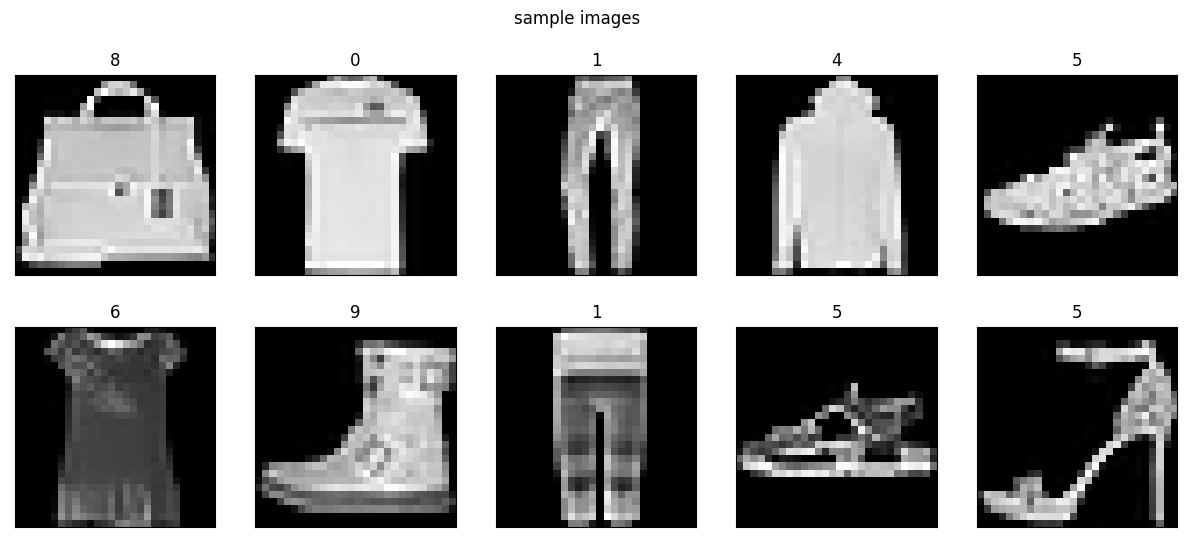

In [232]:
## first 10 samples of train_loader
imgs, labels = next(iter(train_loader))
imgs, labels = imgs[:10], labels[:10]

cols = 5
rows = int(np.ceil(len(labels) / cols))
fig = plt.figure(figsize = (cols*3, rows*3))

for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = fig.add_subplot(rows, cols, i+1, xticks = [], yticks = [])
    ax.imshow(img.permute(1, 2, 0), cmap = 'gray')
    ax.set_title(str(label.item()))

plt.suptitle('sample images')
plt.show()

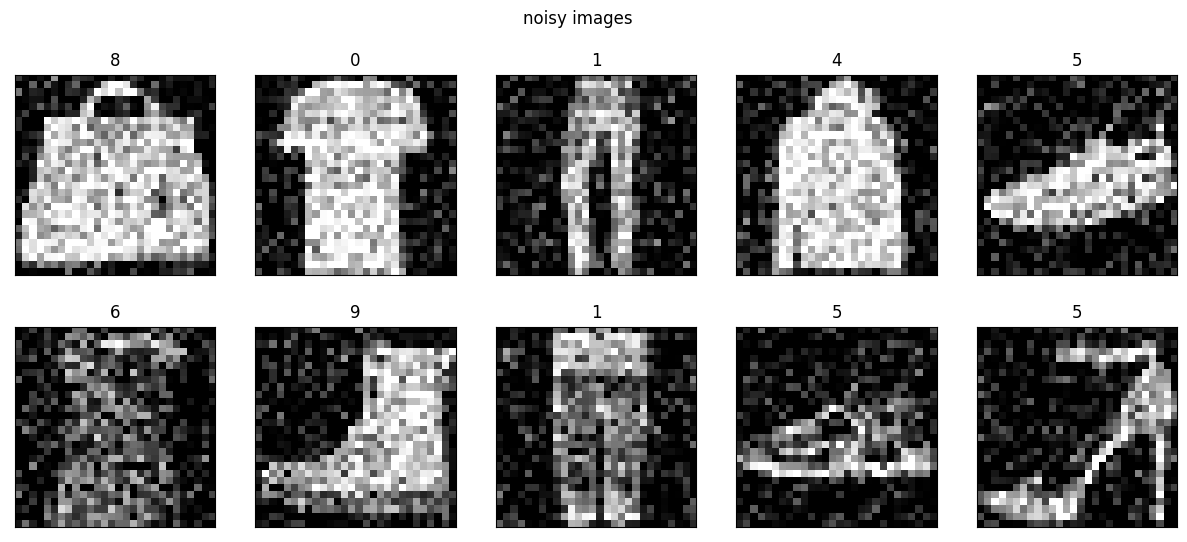

In [233]:
# gaussian noise added to corresponding first 10 samples of train_loader

fig = plt.figure(figsize = (cols*3, rows*3))

for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = fig.add_subplot(rows, cols, i+1, xticks = [], yticks = [])
    noisy_img = gaussian_noise(img)
    ax.imshow(noisy_img.permute(1, 2, 0), cmap = 'gray')
    ax.set_title(str(label.item()))

plt.suptitle('noisy images')
plt.show()

## Autoencoder
4-layer encoding, 4-layer decoding

In [234]:
# fc_layer is combination of fc linear + activation fxn

def fc_layer(in_ft, out_ft, activation, *args, **kwargs):
    return nn.Sequential(
        nn.Linear(in_features = in_ft, out_features = out_ft, *args, **kwargs), 
        activation
    )

# autoencoder class

class AE(nn.Module):

    def __init__(self, activation):
        super(AE, self).__init__()
        self.activation = getattr(nn, activation)()

        self.encoder = nn.Sequential(
            fc_layer(784, 522, self.activation),
            fc_layer(522, 348, self.activation), 
            fc_layer(348, 232, self.activation), 
            fc_layer(232, 155, self.activation)
        )
        
        self.decoder = nn.Sequential(
            fc_layer(155, 232, self.activation),
            fc_layer(232, 348, self.activation), 
            fc_layer(348, 522, self.activation), 
            fc_layer(522, 784, self.activation)
        )

    
    def forward(self, x):
        embeddings = self.encoder(x)
        preds = self.decoder(embeddings)
        return preds

In [235]:
# testing and validation result generator fxn

def validate(model, device, val_loader, loss_fxn):
    model.eval()
    num_batches = 0
    val_loss = 0.0
    val_outputs = []
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            #original img batch
            images =  batch[0]
            #flattened original img batch
            images = torch.flatten(images, 1)
            #flattened noisy img batch
                #.to(torch.float32) to make pytorch compatible
            noisy_images = gaussian_noise(images).to(torch.float32)
            images, noisy_images = images.to(device), noisy_images.to(device)

            # encoding+decoding on noisy batch
            outputs = model(noisy_images)
            val_outputs.append(outputs)
            #loss on original batch
            loss = loss_fxn(outputs, images)

            val_loss += loss.item()

            num_batches = i+1

    val_loss = val_loss / num_batches
    
    return val_loss, val_outputs

In [236]:
# autoencoder training result generator fxn

def fit(model, device, train_loader, num_epochs, optimizer, loss_fxn, val_loader):

    # history lists
    train_losses = []
    val_losses = []

    # train over full data num_epoch times
    for epoch in range(1, num_epochs + 1):
        # alerts model to be ready for training
        model.train()
        # debug
        print(f'#epoch :: {epoch} / {num_epochs}')
        
        # reset temp variables
        train_loss = 0.0
        num_batches = 0
        weights_list = []
        grads_list = []

        # iterate over all batches
        for i, batch in enumerate(train_loader):
            # batch images and labels
                # sending to device is imp.
                # else model(gpu) and data(cpu) will be on different devices
            images =  batch[0]
            images = torch.flatten(images, 1)

            noisy_images = gaussian_noise(images).to(torch.float32)
            images, noisy_images = images.to(device), noisy_images.to(device)
            
            # reset gradients
                # since loss.backward adds over prev. grads
                # therefore resetting after each epoch is necessary
            optimizer.zero_grad()

            # forward propagation
            outputs = model(noisy_images)

            # loss calculation
            loss = loss_fxn(outputs, images)
            # backward propagation
            loss.backward()
            # weight updation
            optimizer.step()
            
            # loss over epoch
            train_loss += loss.item()

            
            # current batch length
            num_batches = i+1
        
        # loss history
        train_loss = train_loss / num_batches
        train_losses.append(train_loss)
        # grads_history.append(grads_list)


        # validation history
        val_loss, val_outputs = validate(model, device, val_loader, loss_fxn)
        val_losses.append(val_loss)

        # debug
        print(f'\ttrain_loss:: {train_loss : .4f}')
        print(f'\tval_loss:: {val_loss : .4f}')
    
    fit_history = train_losses, val_losses
    return fit_history

In [237]:
# AE implementation
    # declaration + initialization + training


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
ae_loss_fxn = nn.MSELoss()
ae_num_epochs = 15

ae_activation = 'Sigmoid'

ae_model = AE(ae_activation).to(device)
ae_optimizer = optim.Adam(ae_model.parameters(), lr=0.001)

ae_train_hist = fit(ae_model, device, train_loader, ae_num_epochs, ae_optimizer, ae_loss_fxn, val_loader)

#epoch :: 1 / 15
	train_loss::  0.0880
	val_loss::  0.0800
#epoch :: 2 / 15
	train_loss::  0.0558
	val_loss::  0.0478
#epoch :: 3 / 15
	train_loss::  0.0475
	val_loss::  0.0453
#epoch :: 4 / 15
	train_loss::  0.0441
	val_loss::  0.0422
#epoch :: 5 / 15
	train_loss::  0.0408
	val_loss::  0.0390
#epoch :: 6 / 15
	train_loss::  0.0357
	val_loss::  0.0331
#epoch :: 7 / 15
	train_loss::  0.0315
	val_loss::  0.0306
#epoch :: 8 / 15
	train_loss::  0.0300
	val_loss::  0.0297
#epoch :: 9 / 15
	train_loss::  0.0292
	val_loss::  0.0291
#epoch :: 10 / 15
	train_loss::  0.0285
	val_loss::  0.0284
#epoch :: 11 / 15
	train_loss::  0.0283
	val_loss::  0.0278
#epoch :: 12 / 15
	train_loss::  0.0274
	val_loss::  0.0273
#epoch :: 13 / 15
	train_loss::  0.0270
	val_loss::  0.0270
#epoch :: 14 / 15
	train_loss::  0.0275
	val_loss::  0.0268
#epoch :: 15 / 15
	train_loss::  0.0265
	val_loss::  0.0266


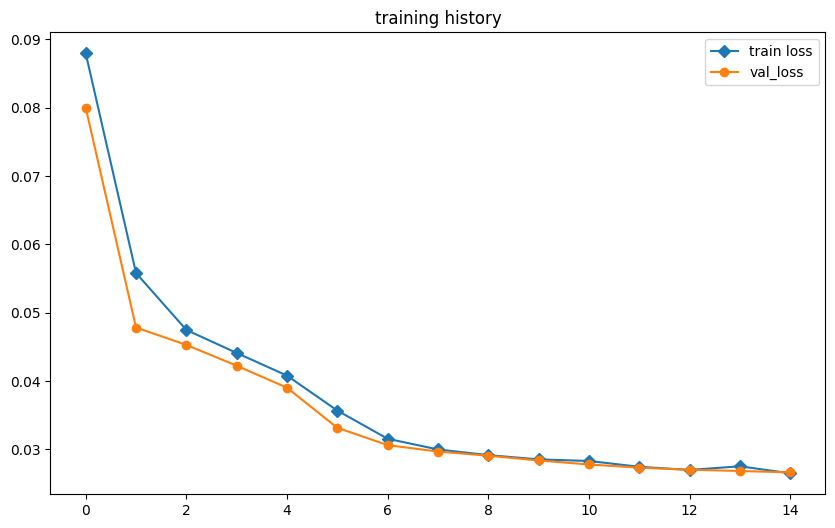

In [238]:
# autoencoder training result history

plt.figure(figsize = (10, 6))
plt.plot(ae_train_hist[0], label = 'train loss', marker = 'D')
plt.plot(ae_train_hist[1], label = 'val_loss', marker = 'o')

plt.title('training history')
plt.legend()
plt.show()

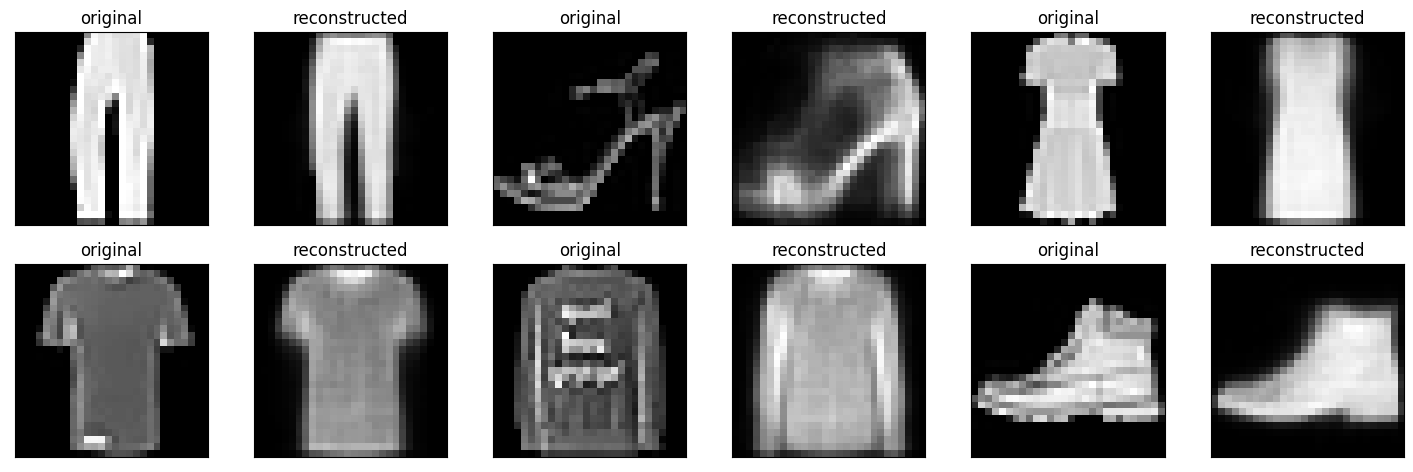

In [239]:
# AE first 6 img samples from validation comparison with decoded output


val_loss, val_outputs = validate(ae_model, device, val_loader, ae_loss_fxn)

in_imgs, labels = next(iter(val_loader))
out_imgs = next(iter(val_outputs))

cols = 6
rows = int(np.ceil(len(labels) / 2))
fig = plt.figure(figsize = (cols*3, rows*3))

for i, (in_img, out_img) in enumerate(zip(in_imgs, out_imgs)):
    if i == cols:
        break

    out_img = out_img.cpu().detach().reshape((1, 28, 28))

    ax = fig.add_subplot(rows, cols, (i*2)+1, xticks = [], yticks = [])
    ax.imshow(in_img.permute(1, 2, 0), cmap = 'gray')
    ax.set_title('original')
    
    ax = fig.add_subplot(rows, cols, (i*2)+2, xticks = [], yticks = [])
    ax.imshow(out_img.permute(1, 2, 0), cmap = 'gray')
    ax.set_title('reconstructed')

# plt.suptitle('sample images')
plt.show()

## AE + MLP Classifier

In [246]:
# encoder from trained auto-encoder model
    #in_size is redundant

class MLP(nn.Module):
    def __init__(self, encoder, in_size, out_size, hl_data, activation):
        super(MLP, self).__init__()
        
        self.activation = getattr(nn, activation)()
        self.encoder = encoder

        #hidden layers
        in_size = 155
        hl_data = [in_size] + list(hl_data[1] for _ in range(hl_data[0]))
        fc_hl_blocks = [fc_layer(in_n, out_n, self.activation) for in_n, out_n in zip(hl_data[:-1], hl_data[1:])]
        

        #output layer
        output_layer = nn.Sequential(
            nn.Linear(in_features = hl_data[-1], out_features = out_size), 
            nn.Softmax(dim = 1) #range(0, 1), sigma(output) = 1
        )

        #mlp
        self.network = nn.Sequential(
            *fc_hl_blocks, 
            output_layer
        )
    

    def forward(self, x):
        x = self.encoder(x)
        pred = self.network(x)
        return pred

In [247]:
# classification validation & prediction result generator function

def mlp_validate(model, device, val_loader, loss_fxn):
    model.eval()
    num_batches = 0
    val_loss, val_acc = 0.0, 0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            images, labels = batch
            images = torch.flatten(images, 1)

            noisy_images = gaussian_noise(images).to(torch.float32)
            noisy_images = noisy_images.to(device)
            images, labels = images.to(device), labels.to(device)

            outputs = model(noisy_images)

            loss = loss_fxn(outputs, labels)
            acc = torch.sum(torch.argmax(outputs, 1) == labels).item() / labels.size(0)

            val_loss += loss.item()
            val_acc += acc

            num_batches = i

    val_loss = val_loss / num_batches
    val_acc = val_acc / num_batches
    
    return val_loss, val_acc

In [248]:
# classfication training result generator fxn

def mlp_fit(model, device, train_loader, num_epochs, optimizer, loss_fxn, val_loader):

    # history lists
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    # train over full data num_epoch times
    for epoch in range(1, num_epochs + 1):
        # alerts model to be ready for training
        model.train()
        # debug
        print(f'#epoch :: {epoch} / {num_epochs}')
        
        # reset temp variables
        train_loss = 0.0
        train_acc = 0
        num_batches = 0
        weights_list = []
        grads_list = []

        # iterate over all batches
        for i, batch in enumerate(train_loader):
            # batch images and labels
                # sending to device is imp.
                # else model(gpu) and data(cpu) will be on different devices
            images, labels = batch
            images = torch.flatten(images, 1)

            noisy_images = gaussian_noise(images).to(torch.float32)
            noisy_images = noisy_images.to(device)
            images, labels = images.to(device), labels.to(device)
            
            # reset gradients
                # since loss.backward adds over prev. grads
                # therefore resetting after each epoch is necessary
            optimizer.zero_grad()

            # forward propagation
            outputs = model(noisy_images)

            # loss calculation
            loss = loss_fxn(outputs, labels)
            # backward propagation
            loss.backward()
            # weight updation
            optimizer.step()
            
            # loss over epoch
            train_loss += loss.item()

            #acc over epoch
            acc = torch.sum(torch.argmax(outputs, 1) == labels).item() / labels.size(0)
            train_acc += acc
            
            # current batch length
            num_batches = i
        
        # loss history
        train_loss = train_loss / num_batches
        train_losses.append(train_loss)

        # acc history
        train_acc = train_acc / num_batches
        train_accs.append(train_acc)



        # validation history
        val_loss, val_acc = mlp_validate(model, device, val_loader, loss_fxn)
        val_losses.append(val_loss)
        val_accs.append(val_acc)


        # debug
        print(f'\ttrain_loss:: {train_loss : .4f},\ttrain_acc:: {train_acc : .4f}')
        print(f'\tval_loss:: {val_loss : .4f},\tval_acc:: {val_acc : .4f}')
    
    fit_history = train_losses, train_accs, val_losses, val_accs
    return fit_history

## fc1 vs fc3

### training

In [249]:
## generate deep copy of encoder
    # this ensures that fc3 doesn't train the encoder pretrained by fc1 

import copy
encoder_c1,  encoder_c2 = copy.deepcopy(ae_model.encoder), copy.deepcopy(ae_model.encoder)

In [250]:
# FC1 implementation
    # declaration + iniatilization + training
    # 0 Hidden Layer + 1 output layer


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = img_size #redundant
output_size = num_class_labels

fc1_hl_data = (0, 64)
fc1_loss_fxn = nn.CrossEntropyLoss()
fc1_num_epochs = 10

fc1_activation = 'Sigmoid'
fc1_model = MLP(encoder_c1, input_size, output_size, fc1_hl_data, fc1_activation).to(device)
print(fc1_model)
fc1_optimizer = optim.Adam(fc1_model.parameters(), lr=0.001)

fc1_train_hist = mlp_fit(fc1_model, device, train_loader, fc1_num_epochs, fc1_optimizer, fc1_loss_fxn, val_loader)

MLP(
  (activation): Sigmoid()
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=522, bias=True)
      (1): Sigmoid()
    )
    (1): Sequential(
      (0): Linear(in_features=522, out_features=348, bias=True)
      (1): Sigmoid()
    )
    (2): Sequential(
      (0): Linear(in_features=348, out_features=232, bias=True)
      (1): Sigmoid()
    )
    (3): Sequential(
      (0): Linear(in_features=232, out_features=155, bias=True)
      (1): Sigmoid()
    )
  )
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=155, out_features=10, bias=True)
      (1): Softmax(dim=1)
    )
  )
)
#epoch :: 1 / 10
	train_loss::  1.7890,	train_acc::  0.7105
	val_loss::  1.7132,	val_acc::  0.7764
#epoch :: 2 / 10
	train_loss::  1.6902,	train_acc::  0.7771
	val_loss::  1.7080,	val_acc::  0.7785
#epoch :: 3 / 10
	train_loss::  1.6824,	train_acc::  0.7841
	val_loss::  1.6968,	val_acc::  0.7887
#epoch :: 4 / 10
	train_loss::  1.6748,	train_ac

In [252]:
# FC3 implementation
    # declaration + iniatilization + training
    # 2 hidden layer + 1 output layer


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
input_size = img_size
output_size = num_class_labels

fc3_hl_data = (2, 64)
fc3_loss_fxn = nn.CrossEntropyLoss()
fc3_num_epochs = 10

fc3_activation = 'Sigmoid'
fc3_model = MLP(encoder_c2, input_size, output_size, fc3_hl_data, fc3_activation).to(device)
print(fc3_model.network)
fc3_optimizer = optim.Adam(fc3_model.parameters(), lr=0.001)

fc3_train_hist = mlp_fit(fc3_model, device, train_loader, fc3_num_epochs, fc3_optimizer, fc3_loss_fxn, val_loader)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=155, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (1): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (2): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)
#epoch :: 1 / 10
	train_loss::  2.0096,	train_acc::  0.4728
	val_loss::  1.8777,	val_acc::  0.6428
#epoch :: 2 / 10
	train_loss::  1.8016,	train_acc::  0.6711
	val_loss::  1.7771,	val_acc::  0.7045
#epoch :: 3 / 10
	train_loss::  1.7509,	train_acc::  0.7158
	val_loss::  1.7767,	val_acc::  0.7192
#epoch :: 4 / 10
	train_loss::  1.7164,	train_acc::  0.7553
	val_loss::  1.7251,	val_acc::  0.7624
#epoch :: 5 / 10
	train_loss::  1.7031,	train_acc::  0.7647
	val_loss::  1.7160,	val_acc::  0.7707
#epoch :: 6 / 10
	train_loss::  1.6951,	train_acc::  0.7717
	val_loss::  1.7021,	val_acc::  0.7845
#epoch :: 7 / 10
	train_loss::  1.6927,	train_acc::  0.7738
	val_loss::  1.6960,

### training comparison

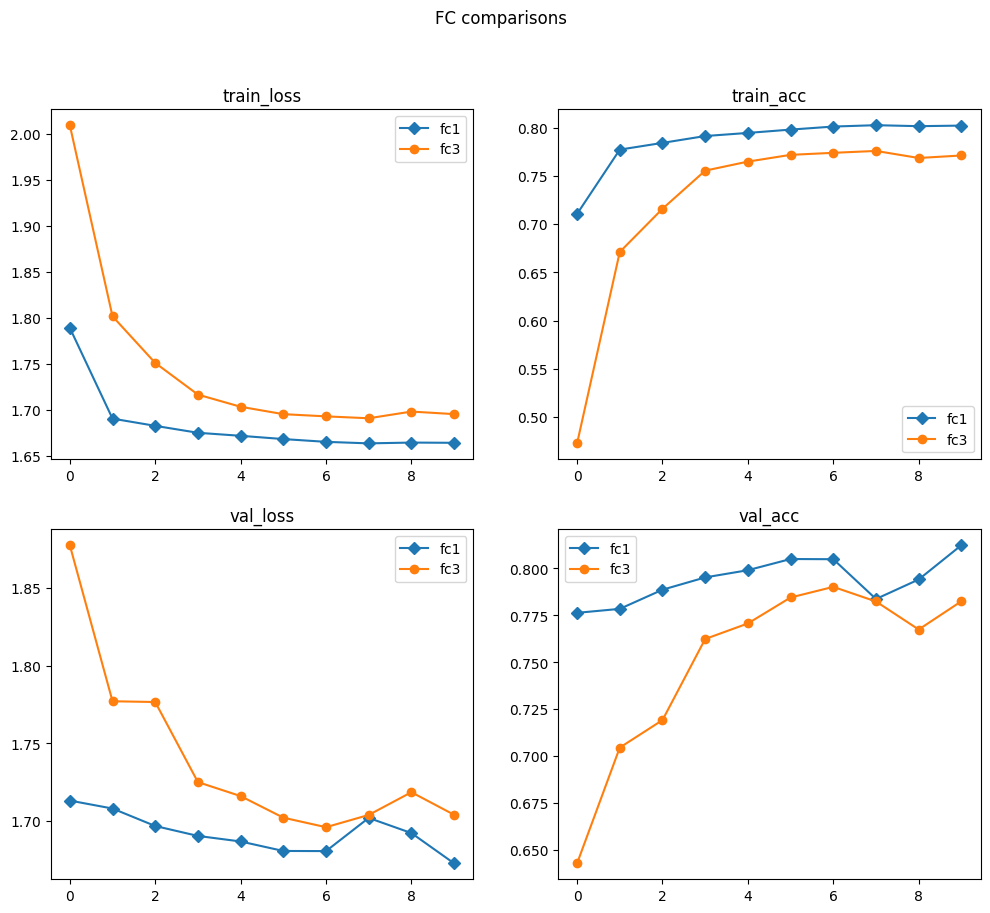

In [253]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
ax[0, 0].plot(fc1_train_hist[0], label = 'fc1', marker = 'D')
ax[0, 1].plot(fc1_train_hist[1], label = 'fc1', marker = 'D')
ax[1, 0].plot(fc1_train_hist[2], label = 'fc1', marker = 'D')
ax[1, 1].plot(fc1_train_hist[3], label = 'fc1', marker = 'D')

ax[0, 0].plot(fc3_train_hist[0], label = 'fc3', marker = 'o')
ax[0, 1].plot(fc3_train_hist[1], label = 'fc3', marker = 'o')
ax[1, 0].plot(fc3_train_hist[2], label = 'fc3', marker = 'o')
ax[1, 1].plot(fc3_train_hist[3], label = 'fc3', marker = 'o')

ax[0, 0].set_title('train_loss')
ax[0, 1].set_title('train_acc')
ax[1, 0].set_title('val_loss')
ax[1, 1].set_title('val_acc')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
plt.suptitle('FC comparisons')

plt.show()

### testing comparison

In [254]:
# test result generation for classification

fc1_test_loss, fc1_test_acc = mlp_validate(fc1_model, device, test_loader, fc1_loss_fxn)
fc3_test_loss, fc3_test_acc = mlp_validate(fc3_model, device, test_loader, fc3_loss_fxn)

fc1_test_loss, fc3_test_loss:: 1.6774192145376494 1.7078387917894307
fc1_test_acc, fc3_test_acc:: 0.807979797979798 0.7781818181818182


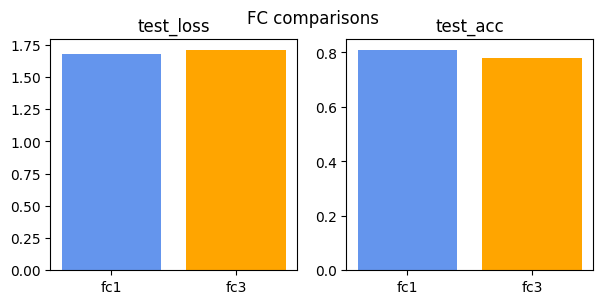

In [255]:
# test loss and accuracy comparison

print('fc1_test_loss, fc3_test_loss::', fc1_test_loss, fc3_test_loss)
print('fc1_test_acc, fc3_test_acc::', fc1_test_acc, fc3_test_acc)

models = ['fc1', 'fc3']
colors = ['cornflowerblue', 'orange']

fig, ax = plt.subplots(1, 2, figsize = (7, 3))

ax[0].bar(models, [fc1_test_loss, fc3_test_loss], label = models, color = colors)
ax[1].bar(models, [fc1_test_acc, fc3_test_acc], label = models, color = colors)

ax[0].set_title('test_loss')
ax[1].set_title('test_acc')

plt.suptitle('FC comparisons')

plt.show()

### reconstruction comparison

In [256]:
## effective reconstruction loader

reconst_loader_1, reconst_loader_2 = [], []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        # original batch
        images, labels = batch
        images = torch.flatten(images, 1)
        # noisy batch
        noisy_images = gaussian_noise(images).to(torch.float32)
        noisy_images = noisy_images.to(device)
        images, labels = images.to(device), labels.to(device)
        # generating embeddings from trained fc1 model
        embeddings_1 = fc1_model.encoder(noisy_images)
        # reconstructing img from embeddings using trained autoencoder
        reconstructed_imgs_1 = ae_model.decoder(embeddings_1)
        # adding new img to loader
        reconst_loader_1.append(reconstructed_imgs_1)
        # ||ly for fc3 classifier
        embeddings_2 = fc3_model.encoder(noisy_images)
        reconstructed_imgs_2 = ae_model.decoder(embeddings_2)
        reconst_loader_2.append(reconstructed_imgs_2)

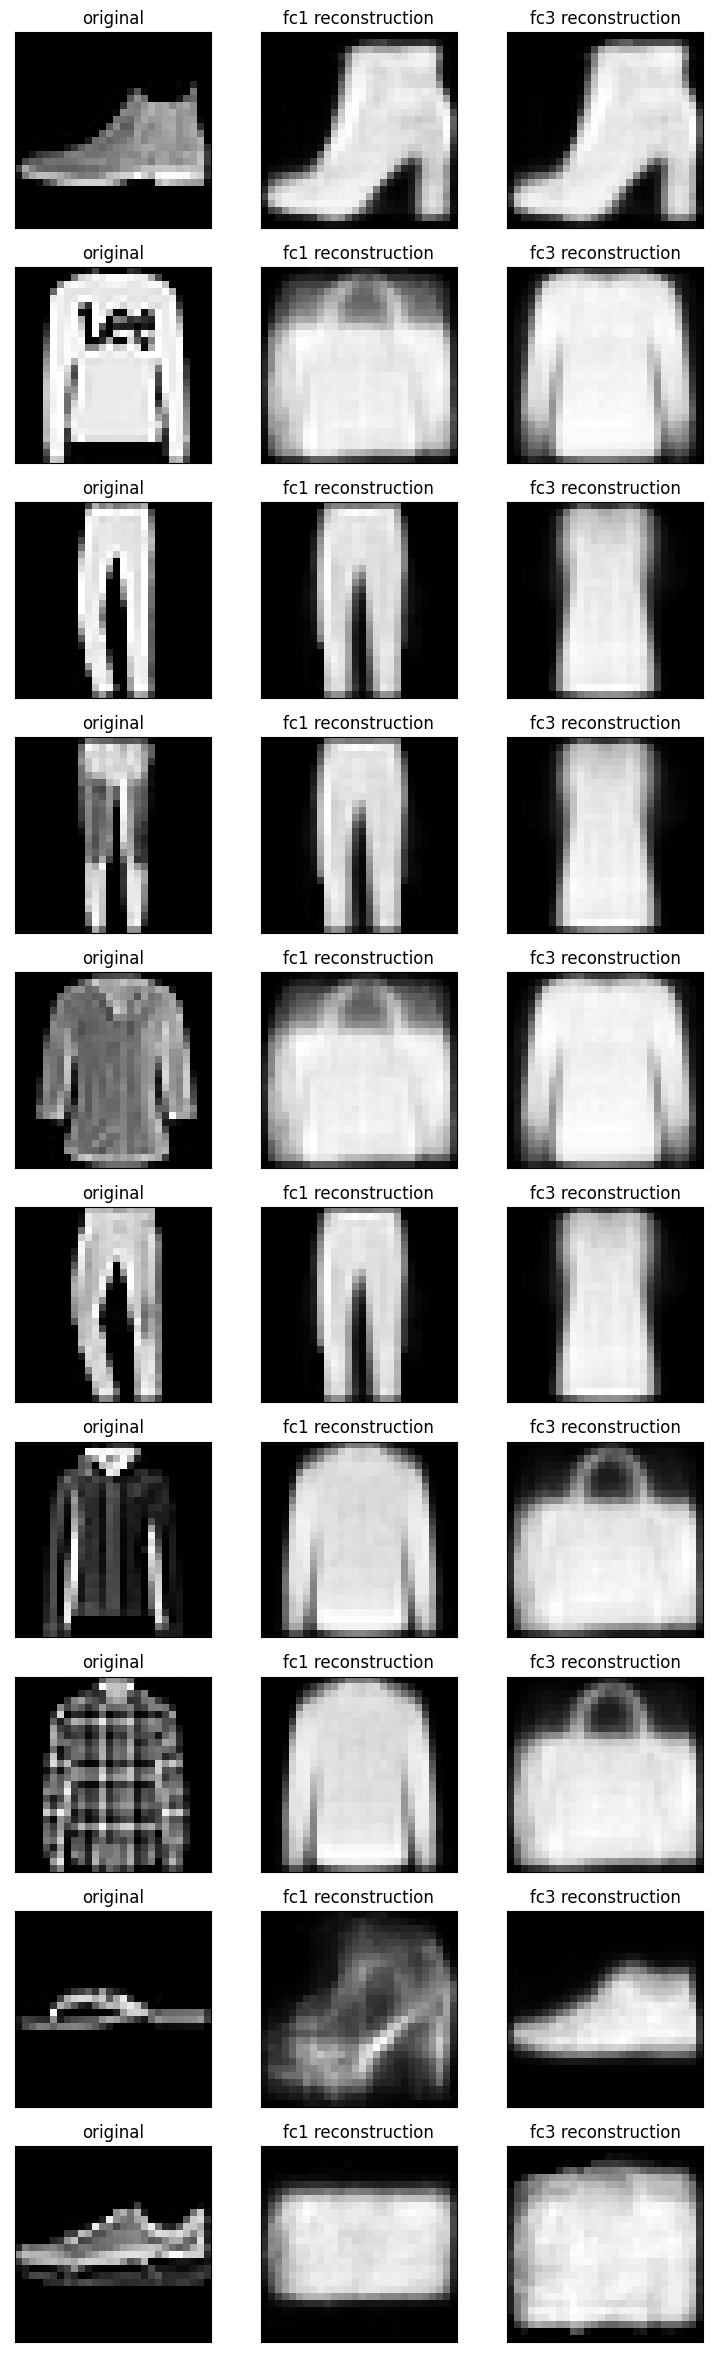

In [257]:
# extracting first batch from test loader, fc1 & fc3 reconstructed loader
in_imgs, labels = next(iter(test_loader))
out_imgs_1 = next(iter(reconst_loader_1))
out_imgs_2 = next(iter(reconst_loader_2))


cols = 3 # comparing original, fc1, fc3 reconstruction
rows = 10 # example
fig = plt.figure(figsize = (cols*3, rows*3))

for i, (in_img, out_img_1, out_img_2) in enumerate(zip(in_imgs, out_imgs_1, out_imgs_2)):
    if i == rows:
        break

    # converting 784 size array to 28x28 image
    out_img_1 = out_img_1.cpu().detach().reshape((1, 28, 28))
    out_img_2 = out_img_2.cpu().detach().reshape((1, 28, 28))
    # plotting 3 columns
    ax = fig.add_subplot(rows, cols, (i*3)+1, xticks = [], yticks = [])
    ax.imshow(in_img.permute(1, 2, 0), cmap = 'gray')
    ax.set_title('original')

    ax = fig.add_subplot(rows, cols, (i*3)+2, xticks = [], yticks = [])
    ax.imshow(out_img_1.permute(1, 2, 0), cmap = 'gray')
    ax.set_title('fc1 reconstruction')
    
    ax = fig.add_subplot(rows, cols, (i*3)+3, xticks = [], yticks = [])
    ax.imshow(out_img_2.permute(1, 2, 0), cmap = 'gray')
    ax.set_title('fc3 reconstruction')

# plt.suptitle('Reconstruction comparision')
plt.show()

## tsne comparison

In [258]:
from sklearn.manifold import TSNE

In [259]:
lt_embed_1, lt_embed_2 = [], []
lt_lb_1, lt_lb_2 = [], []
ln_1, ln_2 = 0, 0

with torch.no_grad():
  # original batch from test loader
  for img, lb in test_loader:
    # generate embedding from fc1 trained encoder
    embed_1 = fc1_model.encoder(img.to(device).view(-1, 784))
    lt_embed_1.append(embed_1.cpu())
    lt_lb_1.append(lb)
    ln_1+=len(img)
    # break as soon as 1000 samples collected
    if(ln_1>=1000):
      break

#||ly for fc3 classifier model
with torch.no_grad():
  for img, lb in test_loader:
    embed_2 = fc3_model.encoder(img.to(device).view(-1, 784))
    lt_embed_2.append(embed_2.cpu())
    lt_lb_2.append(lb)
    ln_2+=len(img)
    if(ln_2>=1000):
      break

In [260]:
embed_tensor_1 = torch.cat(lt_embed_1)
label_tensor_1 = torch.cat(lt_lb_1)

embed_tensor_2 = torch.cat(lt_embed_2)
label_tensor_2 = torch.cat(lt_lb_2)

In [261]:
embed_tensor_1.shape, embed_tensor_2.shape

(torch.Size([1000, 155]), torch.Size([1000, 155]))

In [262]:
tsne_1 = TSNE(n_components=2, random_state=0)
tsne_2 = TSNE(n_components=2, random_state=0)

In [263]:
tsne_data_1 = tsne_1.fit_transform(embed_tensor_1)
tsne_data_2 = tsne_2.fit_transform(embed_tensor_2)

In [264]:
tsne_data_1.shape, tsne_data_2.shape

((1000, 2), (1000, 2))

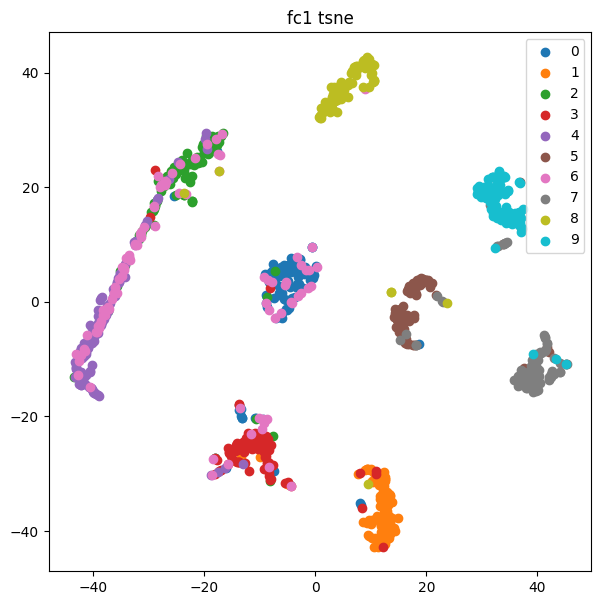

In [265]:
scatter_x = tsne_data_1[:,0]
scatter_y = tsne_data_1[:,1]
group = label_tensor_1

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.title('fc1 tsne')
plt.show()

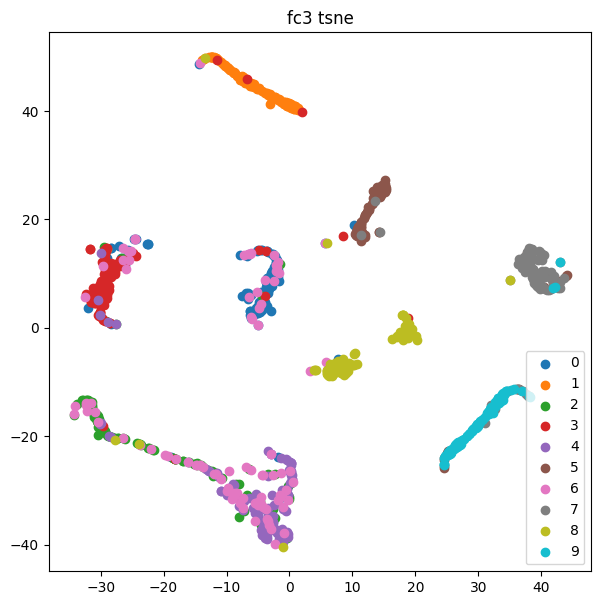

In [266]:
scatter_x = tsne_data_2[:,0]
scatter_y = tsne_data_2[:,1]
group = label_tensor_2

fig, ax = plt.subplots(figsize=(7, 7))
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix],  label = g)
ax.legend()
plt.title('fc3 tsne')
plt.show()